In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Many ML problems - thousands/millions of features for each training instance
# - makes training slow and also harder to find a good solutions - referred to: curse of dimensionality

# Solution - to reduce the dimensionality of the data by removing less important parts
# - it does lose some information which results in slightly worse end result
# - also makes the pipeline more complex and harder to maintain
# - used when training is too slow
# - on the plus side: DR may filter out some noise and unnecessary details and result in higher performance (but not in general)
# - main purpose is to speed up training

# Additionaly, DR can be useful for data visualization - reducing dimensions down to 2/3 allows it to plot a condensed view of high-dimensional training set
# -> can help detecting any patterns, such as clusters
# - also DataViz - essential to communicate your conclusions to people who are not data scientists\

In [3]:
# Curse of Dimensionality
# Behaviours are very different in high-dimensional space:
# e.g. if you pick two points randomly in a unit square, the distance between them will be, on average, roughly 0.52
# - if you do it in 3D - roughly 0.66
# - 1 000 000 dimensional cube -> average distance about 408.25
# -> how can two points be so far apart when they both lie within the same unit cube???
# --> implies that high dimensional datasets are at rish of being very sparse - most trainin instances are likely to be far awy from each other
#   - makes prediction less reliable than in lower dimensions, since they are based on much larger extrapolations

# The more dimension the training set has -> the greater risk of overfitting
# Could solve with more training instaces but sadly the given density grows exponentially with the number of dimensions

In [4]:
# 2 Main approaches for Dimensionality Reduction:
# 1) projections
# 2) Manifold Learning

In [5]:
# Projections
# in most real-world problems: training instances are not spread out uniformly across all dimensions
# many feaures are almost constant, while oters are hihgly correlated (e.g. MNIST)
# -> all training instances actually lie within (or close to) a much lower-dimensional subspace pf the high-D space

# Downsides:
# - if the subspace twists and turns (Swiss roll toy dataset)
# -> by projecting onto a plane -> squash different layers of the Swiss roll toghether
# -> you want to unroll the Swiss roll to obtain the 2D dataset that is representative of the actual data

In [6]:
# Manifold Learning
# - Swiss roll - an example of 2D manifold (= shape that can be bent and twisted in a higher-D space)
# d-dimensional manifold is part of an n-dimensional space (d < n) that locally resembles a d-dimensional hyperplane
# - in case of a Swiss roll, d=2 and n=3: it locally resembles a 2D plane, but it is rolled in the third dimension

# Many DR algorithms worrk by modelling the manifold on which the training instances lie - Manifold Learning
# - relies on manifold assumption (manifold hypothesis) - most real-world high-dimensional datasets lie close to a much lower-dimensional manifold
# (often empirically observed)
# E.g. for MNIST data set (connected lines, borders white, centered, etc.) -> if you randomly generate images, only a few would look like that
# -> DOF for creating a digit <<<< than DOF if you want to creat any image - this constraint tend to squeeze the dataset int a lower d-manifold

# Manifold assumtion often accompanied by another implicit assumption:
# - task at hand will be simpler if express in the lower-dimensional space of the manifold
# * need to be careful since it does not always hold

# Reducing the dimensionality - usually speeds up the training but it may not always lead to better or simpler solutions - depends on the dataset

In [7]:
# PCA - Principal Component Analysis
# - identifies the hyperplane that lies closest to the data, and then projects the data onto it

# Perserving Variance
# - by selecting the axis/hyperplabe that perserves the maximum amount of variance (lose less informatio)
# -> axis that minimizes this is selected based on minimization of mean square distance between the original dataset and its projection onto that axis

In [8]:
# Principal Components
# - the unit vector that defines the i^th axis is called i^th principal component (PC)
# (first one is a line that minimizes mean square distance, second one is orthogonal to the first one, third one is orthogonal to the plane, etc.)

# Note: direction of principal components - not stable:
# - if you perturb the training set slightly and run PCA again, some of new PCs might point in the opposite direction
# - but will generally lie on the same axes

# How to find Principal Components - on page 223 - Singular Value Decomposition

In [9]:
# Test with simple 3D dataset:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [10]:
# Center data and perform Singular Value Decomposition
# Vt - contains all principal components vectors
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

print(c1)
print(c2)

[0.93636116 0.29854881 0.18465208]
[-0.34027485  0.90119108  0.2684542 ]


In [11]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [12]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [13]:
# Projecting Down to d Dimensions
# Once all principal components have been identified -> cna reduce dimensionality of the dataset
# - compute the matrix multiplication of the trainins set X by the matrix W_d
# - W_d: matrix containing the first d principal components, i.e. the matrix composed of the first d columns of V

# Project and center the 3D dataset onto a 2D plane
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

print(X_centered.shape)
print(X2D.shape)

(60, 3)
(60, 2)


In [14]:
# How to use Scikit-Learn to do the same:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [15]:
# Scikit
print(X2D[:5])

[[-1.26203346 -0.42067648]
 [ 0.08001485  0.35272239]
 [-1.17545763 -0.36085729]
 [-0.89305601  0.30862856]
 [-0.73016287  0.25404049]]


In [16]:
# Basic lingalg
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [17]:
# Principal components can be accessed using components_variable
np.allclose(X2D, X2D_using_svd)

True

In [18]:
# To recover 3D points:
X3D_inv = pca.inverse_transform(X2D)

In [19]:
# There's some loss of information so the recovery is not 100% equal the original
np.allclose(X3D_inv, X)

False

In [20]:
# Reconstrunction error:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

np.float64(0.01017033779284855)

In [21]:
# Inverse approach using svd:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])
np.mean(np.sum(np.square(X3D_inv_using_svd - X), axis=1))

np.float64(0.05968660505747196)

In [22]:
# Error is different because PCA automatically takes care of reversing the mean centering
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [23]:
# Principal components
pca.components_

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [24]:
# principal components using SVD:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [25]:
# Axis could be flipped

In [26]:
# Explained Variance Ratio
# - indicates the proportion of the dataset's variance that lies along the axis of each principal component
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [27]:
# Choosing the right number of dimensionsL
# - generally preferable to choose the number of dimension that add up to sufficiently large proportion of the variance (e.g. 95%)
# - unless you want to visualize the data - then choose 2 or 3

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [28]:
# Above applies PCA to MNist dataset that explains at least 95% of the variance
# let's see how many components we need (remember each pixel is one feature)
# original dataset has 784 dimensions
print(d)

154


In [29]:
# You could plug in d to n_components hyperparam but there is a better way:
# n_components accepts values from 0.0-1.0 -> set to 0.95 to automaticall get components for 95% explained variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

np.int64(154)

In [30]:
np.sum(pca.explained_variance_ratio_)

np.float64(0.9503684424557437)

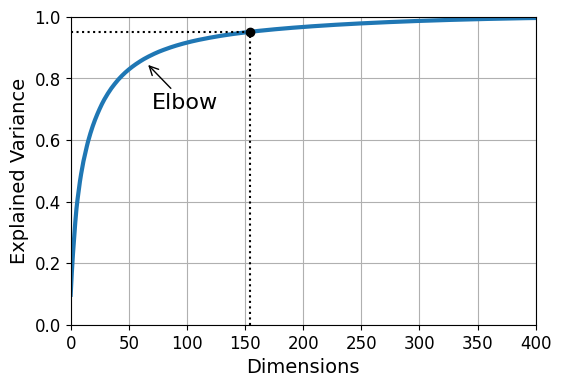

In [31]:
# Can also plot to see the variance vs dimensions/components
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [32]:
# looking at the graph - even going down to 100 dimensions wouldn't lose that much more information\

In [33]:
# PCA for compression
# - reconstruction error - means squared distance between the original data and the reconstructed data

# Let's see how compression looks on the MNIST dataset
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [34]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

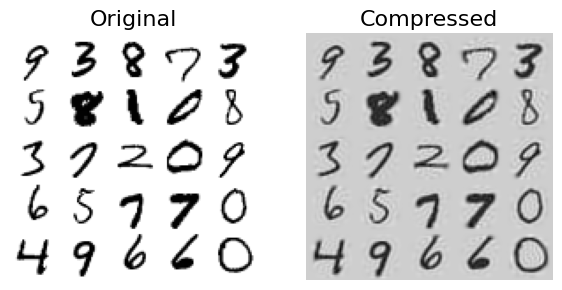

In [36]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)



In [37]:
# Randomnized PCA
# - if svd_solver = randomized - SL uses a stochastic algorithm - Randomized PCA:
# -- quickly finds an approximation of first d principal componenets
# -- complexity is: O(m x d^2) + O(d^3) instead of O(m x n^2) + O(n^3) (full SVD approach)
# -- much faster than full SVD when d << n

rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)
X_reduced_pca = X_reduced

In [38]:
# By deafult svd_salver uses the randomized PCA if m/n is greater then 500 and d is less than 80% of m or n (auto)

In [39]:
# Incremental PCA (IPCA)
# normal PCA - requires whole training set to fit in memory for algorithm to run
# - IPCA - can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time
# - useful for large training sets and also applies to PCA online

In [40]:
# Example: split MNIST dataset into 100 minibatches and feed it to SL's IcrementalPCA class to reduce the dimensionality
# - you must call partial_fit() method with each mini-batch rather than fit() methodv
from sklearn.decomposition import IncrementalPCA

n_batches = 2
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [41]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

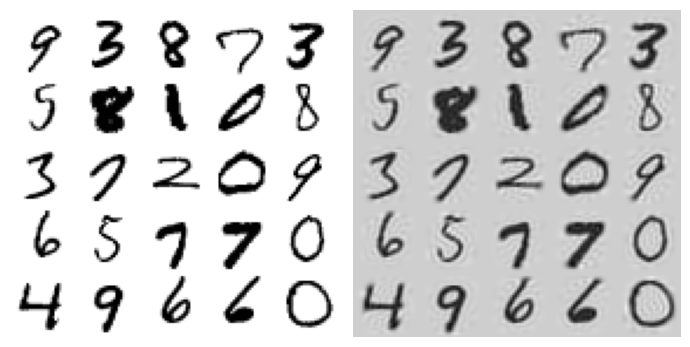

In [42]:
# Let's see if the compression still works okay:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [43]:
X_reduced_inc_pca = X_reduced

In [44]:
# ALso comparing the results
# means are equal:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [45]:
# But the results are not exacly identical - Incremental PCA - good approximate solution but not perfect
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

In [46]:
# Alternatively - Numpy;s memmap class - allows you to manipulate a large array stored in a binary file on disk
# (as if it were entirely in memory)
# cass loads only data it needs in memory when it needs it
# Since the Incremental PCA class uses only a small part of the array at any given time - memory usage remains under control
# - makes it possivle to call the fit() method

# Creating memmap() structure and copy MNIST data into it
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [47]:
# can also delete the memmap(object)
del X_mm

In [48]:
# Anothre program could load the data and use it for training:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=26250, n_components=154)

In [49]:
# Showing time complexity:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 6.9 seconds


KeyboardInterrupt: 

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

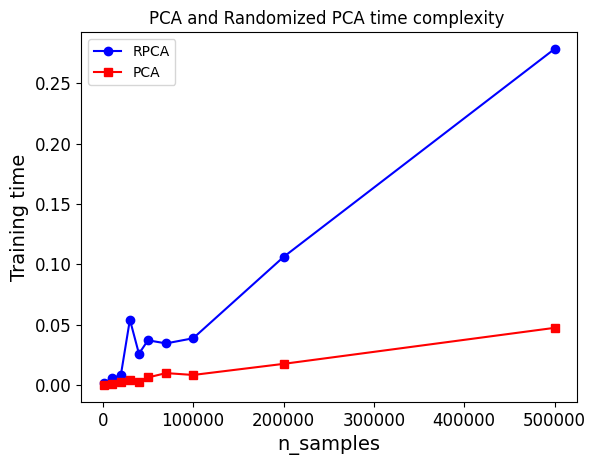

In [50]:
# Comparing PCA & RPCA for datasets of different sizes
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

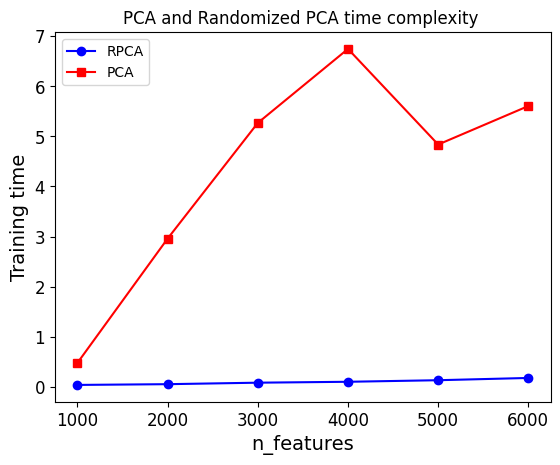

In [51]:
# Differences in their performance on dataset of 2000 instances with various number of features
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

In [52]:
# Kernel PCA
# - Kernel trick - implicitly maps instances into a very high-dimensional space (feature space)
# --> enables nonlinear classification and regression with Support Vector Machines 
#   (Linear decision boundary in the high-dimensional feature space dcorresponds to a complex nonlinear decision boundary in the original space)
# - same can be done to PCA - can perform complex nonlinear projections for dimensionality reduction - kernel PCA

# often good at perserving clusters of instances after proijection, sometimes even unrolling datasets that lie close to a twisted manifold

In [54]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

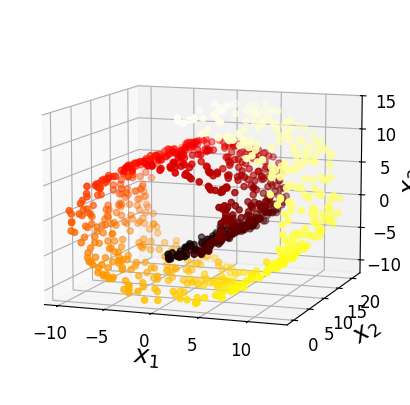

In [55]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

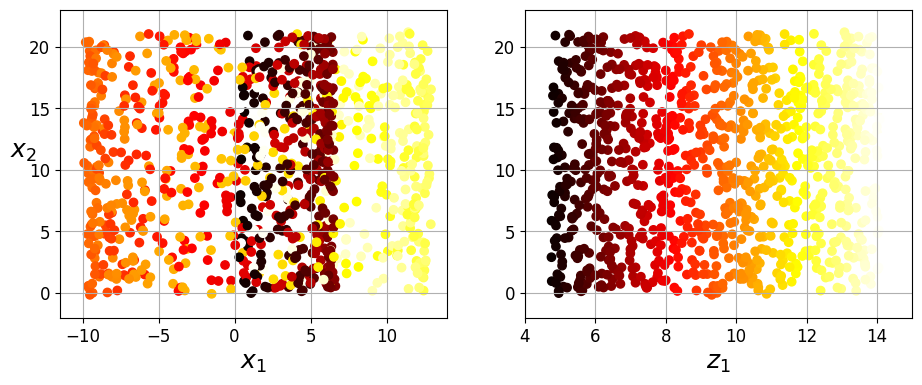

In [58]:
## Squished swiss roll
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

In [59]:
# Can try using SL - KernelPCA calss to perfrom kPCA with an RBF kernel witj RBG kernel
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

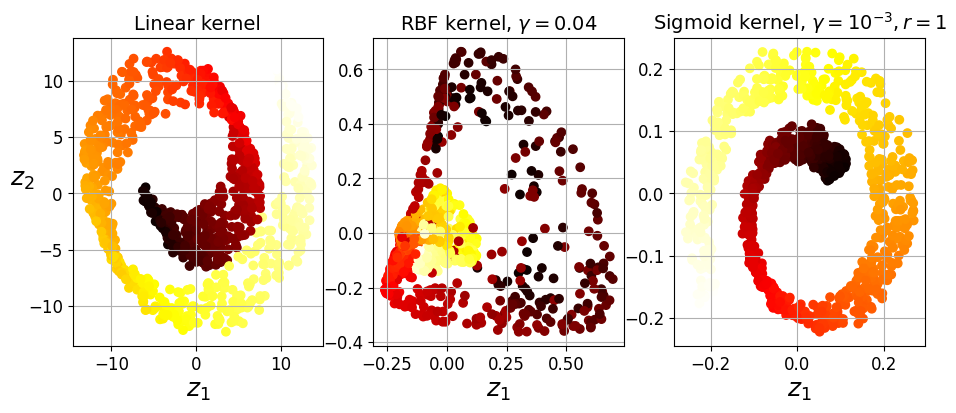

In [60]:
# Let's see how it looks on 2D subspace
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [63]:
# Three different kernels used: Linear, RBG and Sigmoid kernel (Logistic)
# But how to Find the best kernel and its right hyperparams?

# kPCA - unsupervised learning algorithms - no obvious performance measure to select the right params
# - often is just a prepareation step for a supervised learning task - can simply apply gridsearch to select the kernel and right params
# Example:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [64]:
# The best kernel and hyperparams available through best_params_ variable
print(grid_search.best_params_)

{'kpca__gamma': np.float64(0.043333333333333335), 'kpca__kernel': 'rbf'}


In [67]:
# Another approach - entirely unsupervised
# Select a kernel and hyperparams that yield the lowest reconstruction error
# - reconstruction is not as easy at with linear PCA
# - by using a kernel - maps the training set to an infinite-dimensional feature space 
# -> the reconstructed point cannot be computed due to infinite-dimensional feature space -> cannot get the reconstruction error
# - However, we can find a point in the original space that maps close to the reconstructed point - called pre-image (reconstruction)
# - with pre-image - one can measure its squared distance to the original instance
# - then the kernel and hyperparams can be selected that minimize this reconstruction error

# Trained supervised regression model can be trained to project instances as the training set and the original instances as targets
# Done automatically if in SL if fit_inverse_transform=True (by default is set to false):
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [68]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

np.float64(32.78630879576615)

In [69]:
# Then GridSearch can be used with cross-validation to find the kernel and hyperparams that minimize this pre-image reconstruction error